# Goal: Create a model that can classify fruit images


In [1]:
!unzip fruits-small.zip

Archive:  fruits-small.zip
   creating: fruits-small/
   creating: fruits-small/data/
   creating: fruits-small/data/Training/
   creating: fruits-small/data/Training/Banana/
  inflating: fruits-small/data/Training/Banana/0_100.jpg  
  inflating: fruits-small/data/Training/Banana/104_100.jpg  
  inflating: fruits-small/data/Training/Banana/107_100.jpg  
  inflating: fruits-small/data/Training/Banana/10_100.jpg  
  inflating: fruits-small/data/Training/Banana/112_100.jpg  
  inflating: fruits-small/data/Training/Banana/117_100.jpg  
  inflating: fruits-small/data/Training/Banana/118_100.jpg  
  inflating: fruits-small/data/Training/Banana/119_100.jpg  
  inflating: fruits-small/data/Training/Banana/11_100.jpg  
  inflating: fruits-small/data/Training/Banana/120_100.jpg  
  inflating: fruits-small/data/Training/Banana/121_100.jpg  
  inflating: fruits-small/data/Training/Banana/122_100.jpg  
  inflating: fruits-small/data/Training/Banana/123_100.jpg  
  inflating: fruits-small/data/Train

In [96]:
import tensorflow as tf

In [97]:
# Preprocessing --- Goal is to make your data compatible for CNN !!!
# Tensorflow offers direct classes to achieve the same
#
# Normalize/scaling of input image
#
# Image Generators
# rescale= 1.0 / 255.  ensures my intensities of each pixel will be in the range of 0 - 255 (Image Normalization)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator( rescale= 1.0 / 255. )
test_generator = tf.keras.preprocessing.image.ImageDataGenerator( rescale= 1.0 / 255. )

In [98]:
# Pass the images through generator to generate compatible inputs

trainImageData = train_generator.flow_from_directory('fruits-small/data/Training' ,
                                                    batch_size=20,    #How many images to pass per tick
                                                    class_mode='categorical', #binary --- Binary Classification | categorical --- Multiclass classification
                                                    target_size=(64,64))


testImageData = train_generator.flow_from_directory('fruits-small/data/Validation' ,
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(64,64))

Found 3425 images belonging to 7 classes.
Found 1150 images belonging to 7 classes.


In [99]:
# create label map
print()
trained_label_map = trainImageData.class_indices
print("Trained label map\n", trained_label_map)
print()
testing_label_map = dict((v,k) for k,v in trained_label_map.items())
print("Testing label map\n", testing_label_map)


Trained label map
 {'Banana': 0, 'Lemon': 1, 'Mango': 2, 'Orange': 3, 'Pineapple': 4, 'Pomegranate': 5, 'Strawberry': 6}

Testing label map
 {0: 'Banana', 1: 'Lemon', 2: 'Mango', 3: 'Orange', 4: 'Pineapple', 5: 'Pomegranate', 6: 'Strawberry'}


In [100]:
# Architect our CNN
trainImageData.image_shape

(64, 64, 3)

In [101]:
model = tf.keras.Sequential()

# Step1: Create First Convolutional Layer
# Convolve Layer ----- Return n FeatureMaps where n is noFeatureMaps
model.add(tf.keras.layers.Conv2D(32 , (3,3) , input_shape = (64, 64, 3) , activation = 'relu' , padding='same'))
# Pooling Layer
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2) ))
# model.add(tf.keras.layers.AveragePooling2D(pool_size = (2,2) ))

# Step2: Create Second Convolutional Layer
# Convolve Layer
model.add(tf.keras.layers.Conv2D(16 , (3,3) , activation = 'relu' , padding='same'))
# Pooling Layer
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2) ))

# Step3: Flatten
model.add(tf.keras.layers.Flatten())

# Step4: FC LAyer | ANN Layer
model.add(tf.keras.layers.Dense(units= 512 , activation = 'relu'))
model.add(tf.keras.layers.Dense(units= 256 , activation = 'relu'))

# output layer
model.add(tf.keras.layers.Dense(units= 7 , activation = 'softmax'))

In [102]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 16, 16, 16)        0         
 ng2D)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 4096)              0         
                                                                 
 dense_15 (Dense)            (None, 512)              

In [103]:
# Compile
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=['accuracy']
  )

In [104]:
int(len(trainImageData.filenames) / trainImageData.batch_size)

171

In [105]:
# early stopping callback function
class MyCLRuleCallback(tf.keras.callbacks.Callback):
  def __init__(self,cl):
    super(MyCLRuleCallback, self).__init__()
    self.cl=cl

  def on_epoch_end(self, epoch, logs=None):
    testScore = logs["val_accuracy"]
    trainScore = logs["accuracy"]

    if testScore > trainScore and testScore - trainScore < 0.05 and testScore >= self.cl:
      self.model.stop_training=True

In [106]:
# Fit
# steps_per_epoch -- applicable for training data  ------- no_images_training_set/batchSize
# validation_steps-- applicable for testing data   ------- no_images_testing_set/batchSize

myR2ScoreMonitor = MyCLRuleCallback(cl=0.9)

history = model.fit(
    trainImageData,
    validation_data=testImageData,
    epochs=50,
    steps_per_epoch= int(len(trainImageData.filenames) / trainImageData.batch_size), #No of Images / batch size
    validation_steps= int(len(testImageData.filenames) / testImageData.batch_size),
    callbacks=[myR2ScoreMonitor]
  )

Epoch 1/50
171/171 [==============================] - 4s 17ms/step - loss: 0.0570 - accuracy: 0.9310 - val_loss: 0.0113 - val_accuracy: 0.9930
Epoch 2/50
171/171 [==============================] - 6s 33ms/step - loss: 0.0011 - accuracy: 0.9994 - val_loss: 7.7964e-04 - val_accuracy: 1.0000


In [109]:
model.save('fruit_identifier.keras')

import pickle
pickle.dump(testing_label_map, open("testing_label_map","wb"))

Use the model to classify the image

In [110]:
import tensorflow as tf
import numpy as np
import pickle

model_1 = tf.keras.models.load_model('fruit_identifier.keras')
testing_label_map_1 = pickle.load(open("testing_label_map", "rb"))

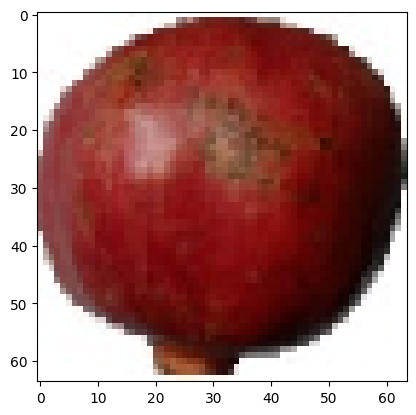

In [111]:
img = tf.keras.preprocessing.image.load_img('fruits-small/data/Validation/Pomegranate/326_100.jpg' , target_size=(64,64))

import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(img)

In [112]:
imgArray = tf.keras.preprocessing.image.img_to_array(img)

imgArray.shape

(64, 64, 3)

In [113]:
import numpy as np
compatibleImgArray = np.expand_dims(imgArray, axis=0)

compatibleImgArray.shape

(1, 64, 64, 3)

In [114]:
model_1.predict(compatibleImgArray)

1/1 [==============================] - 0s 98ms/step


array([[0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [115]:
testing_label_map_1

{0: 'Banana',
 1: 'Lemon',
 2: 'Mango',
 3: 'Orange',
 4: 'Pineapple',
 5: 'Pomegranate',
 6: 'Strawberry'}

In [116]:
predicted_fruit = testing_label_map_1[np.argmax(model_1.predict(compatibleImgArray))]
print(f'Above image is `{predicted_fruit}`')

1/1 [==============================] - 0s 18ms/step
Above image is `Pomegranate`
